In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
import pymorphy2

from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords
from razdel import tokenize

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
D:\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Игорь\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

In [7]:
len(stopword_ru)

151

In [8]:
with open('stopwords.txt', encoding='utf-8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
stopword_ru[145:155]

['им', 'более', 'всегда', 'конечно', 'всю', 'между', 'год', 'и', 'в', 'во']

In [10]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cache = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cache)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [11]:
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

In [12]:
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

In [13]:
news.head()

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."


In [14]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)

In [15]:
len(common_dictionary)

141166

In [16]:
common_dictionary.filter_extremes(no_above=0.2)
len(common_dictionary)

38456

In [17]:
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [18]:
NUM_TOPICS = 18

In [19]:
from gensim.models import LdaMulticore
lda = LdaMulticore(common_corpus, num_topics=NUM_TOPICS, id2word=common_dictionary, random_state=14, passes=25)

In [20]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[3000:3005]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['председатель', 'совет', 'федерация', 'валентина', 'матвиенко', 'член', 'совфеда', 'уличить', 'управление', 'бизнес', 'лишить', 'мандат', 'сенатор', 'интерфакс', 'nn', 'комиссия', 'совет', 'федерация', 'противодействие', 'коррупция', 'течение', 'месяц', 'проверка', 'предмет', 'владение', 'сенатор', 'иной', 'бизнес', 'ход', 'проверка', 'выявить', 'факт', 'управление', 'сенатор', 'бизнес', 'лишить', 'мандат', 'регион', 'чей', 'интерес', 'представлять', 'палата', 'обязать', 'отозвать', 'матвиенко', 'nn', 'последний', 'аналогичный', 'проверка', 'проводиться', 'некоторый', 'депутат', 'госдума', 'сенатор', 'совфеда', 'закон', 'запретить', 'заниматься', 'предпринимательский', 'деятельность', 'прошлый', 'неделя', 'профильный', 'комиссия', 'госдума', 'решить', 'проводить', 'проверка', 'достоверность', 'сведение', 'доход', 'имущество', 'четыре', 'пять', 'депутатовединоросс', 'материал', 'якобы', 'иметься', 'парламентарий', 'бизнес', 'предоставить', 'лидер', 'думский', 'фракция', 'эсер', 'сергей

[(8, 0.99116945)]

In [21]:
x=lda.show_topics(num_words=15, num_topics=NUM_TOPICS,formatted=False)# num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic, words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: самолёт военный сирия сила американский ракета оружие оборона ядерный сирийский боевой система нато вооружение территория
topic_1: наука научный ран технология проект развитие институт путин очень академия форум проблема учёный уголь университет
topic_2: исследование мозг ребёнок исследователь женщина заболевание риск учёный рак врач пациент случай болезнь развитие жизнь
topic_3: россиянин рост доход тыс население уровень рубль пенсия зарплата составить цена руб вырасти эксперт млн
topic_4: ракета космический спутник аппарат запуск миссия орбита луна космос nasa полёт земля пуск корабль роскосмос
topic_5: учёный земля исследование планета исследователь животное солнечный обнаружить луна звезда солнце система университет объект поверхность
topic_6: турист турция греция температура регион мс турецкий погода туристический туризм °с курорт аэропорт тыс ветер
topic_7: музей фильм команда хороший век матч культура игра фестиваль найти сайт археолог памятник мир клуб
topic_8: украина

In [22]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(NUM_TOPICS):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(NUM_TOPICS)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(NUM_TOPICS)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17
0,6,0.0,0.000000,0.0,0.000000,0.044549,0.000000,0.0,0.151179,0.67677,0.000000,0.000000,0.000000,0.0,0.000000,0.097253,0.0,0.000000,0.023413
1,4896,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.614395,0.00000,0.298852,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.062853,0.000000
2,4897,0.0,0.063683,0.0,0.000000,0.060988,0.000000,0.0,0.804207,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.050034,0.0,0.000000,0.000000
3,4898,0.0,0.000000,0.0,0.052199,0.000000,0.011659,0.0,0.615397,0.00000,0.000000,0.238435,0.072424,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,4899,0.0,0.157359,0.0,0.000000,0.000000,0.000000,0.0,0.182241,0.58918,0.000000,0.000000,0.000000,0.0,0.048075,0.000000,0.0,0.000000,0.000000


In [24]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [25]:
class MyTfidf:
    def __init__(self):
        self.idf = {}
        
    def fit(self, users):
        #создаем словарь и считаем частоты по статьям
        for user in users:
            for article in user:
                if article in self.idf.keys():
                    self.idf[article] += 1
                else:
                    self.idf[article] = 1
        #общее количество статей
        counts = np.sum([i for i in self.idf.values()])
        
        #считаем сам IDF
        for key in self.idf.keys():
            self.idf[key] = np.log(self.idf[key] / counts)
        
        #и нормализуем его на интервал от 1 до 2
        _tmp = np.array([i for i in self.idf.values()])
        _min = np.min(_tmp)
        _max_min = np.max(_tmp) - np.min(_tmp)
        
        for key in self.idf.keys():
            self.idf[key] = (self.idf[key] - _min) / _max_min + 1
            
    def idf_num(self, article):
        return self.idf[article]
            

In [26]:
idf = MyTfidf()
idf.fit([eval(i) for i in users['articles']])

idf.idf_num(995)

1.4893010842364522

In [27]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(NUM_TOPICS)]].values))

In [28]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.55100548, 0.17245527, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.26644716, 0.        ])

In [29]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [30]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [31]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [32]:
def get_user_embedding_tfidf(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    idf_weights = np.array([idf.idf_num(article) for article in user_articles_list])
    user_vector = user_vector.T.dot(idf_weights / idf_weights.sum()).T
    return user_vector

In [33]:
def make_dataset(func):
    dataset = pd.DataFrame([i for i in users['articles'].apply(lambda x: func(x), 1)])
    dataset.columns = ['topic_{}'.format(i) for i in range(NUM_TOPICS)]
    dataset['uid'] = users['uid'].values
    dataset = dataset[['uid']+['topic_{}'.format(i) for i in range(NUM_TOPICS)]]
    return dataset
    

In [34]:
func_list = [get_user_embedding, get_user_embedding_median, get_user_embedding_max, get_user_embedding_tfidf]

datasets = []

for func in func_list:
    datasets.append(make_dataset(func))
    
len(datasets)

4

In [35]:
datasets[0].head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17
0,u105138,0.040009,0.000000,0.003768,0.014268,0.000000,0.000000,0.000000,0.383435,0.175927,0.070567,0.103164,0.000000,0.000000,0.021434,0.000000,0.000000,0.148880,0.020595
1,u108690,0.024249,0.036794,0.086687,0.060332,0.000000,0.002242,0.000000,0.051306,0.177304,0.021310,0.113256,0.165869,0.005494,0.024447,0.001680,0.038849,0.183209,0.002641
2,u108339,0.031248,0.000000,0.011762,0.003300,0.000000,0.001991,0.120101,0.016930,0.152762,0.174697,0.207053,0.012335,0.083330,0.000000,0.000000,0.026851,0.153834,0.000000
3,u101138,0.039813,0.053015,0.005197,0.032921,0.004166,0.095788,0.000000,0.355651,0.000000,0.026614,0.139811,0.010851,0.158435,0.000000,0.002695,0.030891,0.032433,0.000000
4,u108248,0.000000,0.003582,0.099059,0.004325,0.000000,0.051986,0.163902,0.043795,0.207336,0.000000,0.113426,0.029485,0.009735,0.007338,0.000000,0.043114,0.206074,0.012366


In [36]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [37]:
for i in range(len(datasets)):
    datasets[i] = pd.merge(datasets[i], target, 'left')
    
datasets[3].head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,churn
0,u105138,0.043763,0.000000,0.003817,0.014452,0.000000,0.000000,0.000000,0.372252,0.175775,0.071476,0.114397,0.000000,0.000000,0.021710,0.000000,0.000000,0.140409,0.023571,0
1,u108690,0.027665,0.033114,0.099715,0.060919,0.000000,0.002047,0.000000,0.046845,0.157591,0.015632,0.100209,0.199641,0.005593,0.028122,0.001710,0.028499,0.185765,0.002411,1
2,u108339,0.031549,0.000000,0.014116,0.003170,0.000000,0.002052,0.126164,0.020319,0.166743,0.140377,0.224111,0.012715,0.085901,0.000000,0.000000,0.027679,0.141023,0.000000,1
3,u101138,0.040672,0.050466,0.005590,0.032454,0.004256,0.097855,0.000000,0.347203,0.000000,0.027188,0.144717,0.009264,0.161761,0.000000,0.002565,0.032544,0.031700,0.000000,0
4,u108248,0.000000,0.003480,0.102498,0.003914,0.000000,0.051669,0.159209,0.046460,0.213612,0.000000,0.113839,0.028227,0.009956,0.007505,0.000000,0.041879,0.200469,0.012647,1


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
results = []

for index, dataset in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(dataset[['topic_{}'.format(i) for i in range(NUM_TOPICS)]], 
                                                        dataset['churn'], random_state=0)
    
    logreg = LogisticRegression()#C=5, class_weight='balanced')
    logreg.fit(X_train, y_train)
    
    preds = logreg.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    
    ix = np.argmax(fscore)
    
    #best_treshold, best_fscore, best_precision, best_recall = thresholds[ix], fscore[ix], precision[ix], recall[ix]
    roc_auc = roc_auc_score(y_test, preds)
    
    name = func_list[index].__name__
    
    results.append([name, preds, roc_auc, precision[ix], recall[ix], fscore[ix], thresholds[ix]])
    
results = pd.DataFrame(results, columns=['EmbeddingFunction', 'preds', 'roc_auc', 'precision', 'recall', 'f_score', 'thresholds'])
results

,EmbeddingFunction,preds,roc_auc,precision,recall,f_score,thresholds
0,get_user_embedding,"[0.025390248727255135, 0.0019879106933679623, ...",0.978713,0.844156,0.795918,0.819328,0.412778
1,get_user_embedding_median,"[0.12029962327511082, 0.0019343842029139735, 0...",0.956139,0.643098,0.779592,0.704797,0.272495
2,get_user_embedding_max,"[0.0072720509514806, 0.0011571713592008, 0.983...",0.953516,0.718631,0.771429,0.744094,0.338160
3,get_user_embedding_tfidf,"[0.031002925568208366, 0.0023684938821562167, ...",0.976375,0.789683,0.812245,0.800805,0.373973


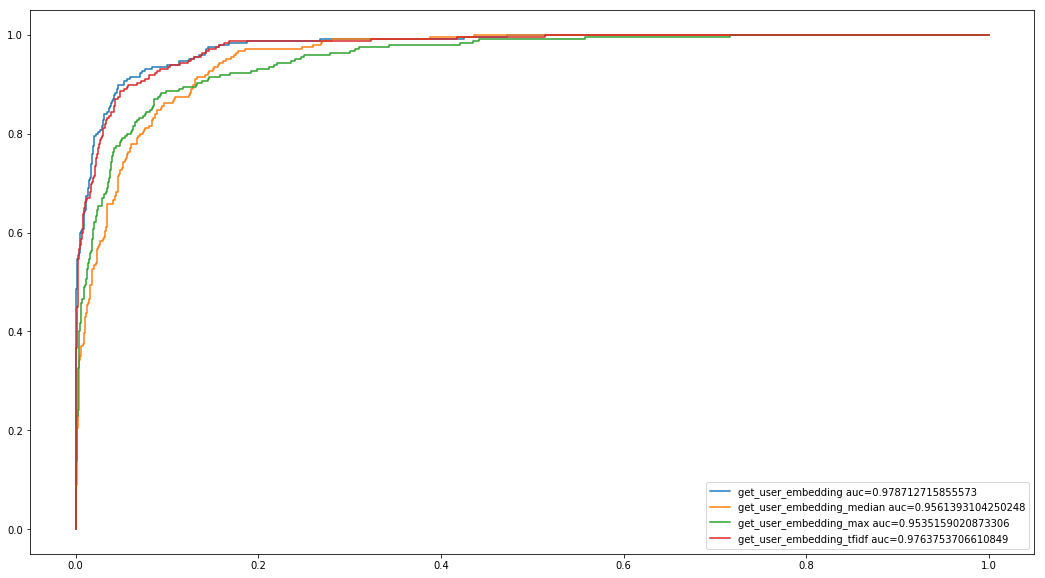

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(18,10))

for i in range(4):
    fpr, tpr, _ = roc_curve(y_test,  results.iloc[i]['preds'])
    auc = roc_auc_score(y_test, results.iloc[i]['preds'])
    plt.plot(fpr, tpr, label = f"{results.iloc[i]['EmbeddingFunction']} auc={auc}")
             
plt.legend(loc=4)
plt.show()

In [41]:
from catboost import CatBoostClassifier

In [42]:
results = []

for index, dataset in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(dataset[['topic_{}'.format(i) for i in range(NUM_TOPICS)]], 
                                                        dataset['churn'], random_state=0)
    
    model = CatBoostClassifier(iterations=15000,
                           learning_rate=0.004,
                           early_stopping_rounds = 150,
                           verbose = False,
                           custom_metric = ['Logloss', 'AUC'])

    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
    preds = model.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    
    ix = np.argmax(fscore)
    
    roc_auc = roc_auc_score(y_test, preds)
    
    name = func_list[index].__name__
    
    results.append([name, preds, roc_auc, precision[ix], recall[ix], fscore[ix], thresholds[ix]])
    
results = pd.DataFrame(results, columns=['EmbeddingFunction', 'preds', 'roc_auc', 'precision', 'recall', 'f_score', 'thresholds'])
results

,EmbeddingFunction,preds,roc_auc,precision,recall,f_score,thresholds
0,get_user_embedding,"[0.0006078476492610218, 7.370608239670726e-05,...",0.988544,0.838951,0.914286,0.875000,0.338851
1,get_user_embedding_median,"[0.28935454455205584, 0.0011774888329492408, 0...",0.979192,0.817814,0.824490,0.821138,0.462027
2,get_user_embedding_max,"[0.000685558794552239, 0.00014400340154401513,...",0.983022,0.908257,0.808163,0.855292,0.480886
3,get_user_embedding_tfidf,"[0.00018191243205141494, 4.8851345061928755e-0...",0.988390,0.877551,0.877551,0.877551,0.457926


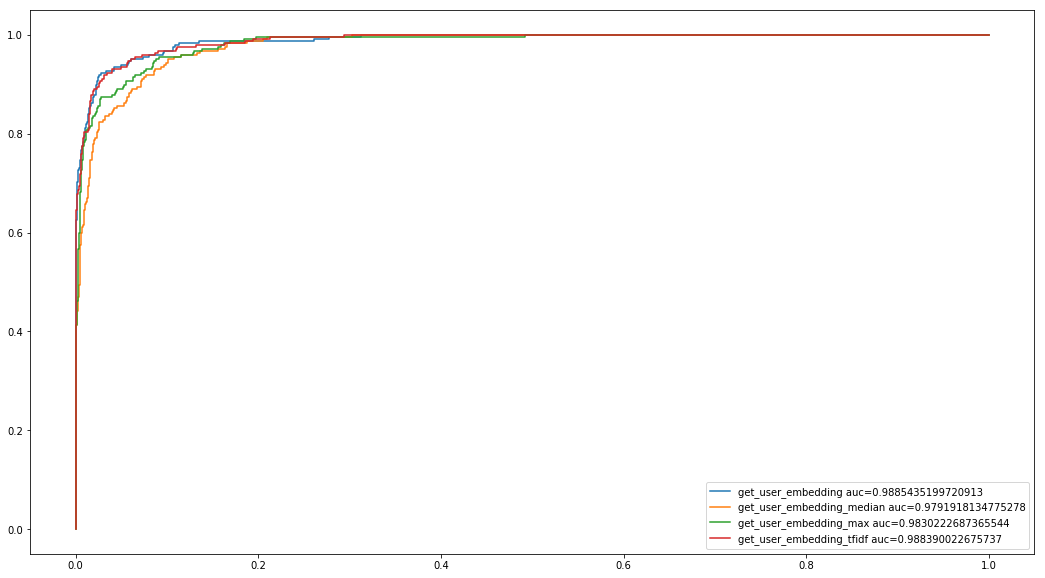

In [43]:
plt.figure(figsize=(18,10))

for i in range(4):
    fpr, tpr, _ = roc_curve(y_test,  results.iloc[i]['preds'])
    auc = roc_auc_score(y_test, results.iloc[i]['preds'])
    plt.plot(fpr, tpr, label = f"{results.iloc[i]['EmbeddingFunction']} auc={auc}")
             
plt.legend(loc=4)
plt.show()